<h2>CIFAR-10 Image Classification</h2>
<h3>ST1504 Deep Learning CA1 Part B</h3>

##### Name: Haja Amir Rahman
##### Class: DAAA/FT/2B/06
##### Admin Number: P2100803

### References:
- [CIFAR-100 Dataset - Keras](https://keras.io/api/datasets/cifar100/)
- [CIFAR100 Homepage](https://www.cs.toronto.edu/~kriz/cifar.html)
- [Kaggle-CIFAR100](https://www.kaggle.com/datasets/fedesoriano/cifar100)
- [EfficientNetV2](https://arxiv.org/abs/2104.00298)
    
<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images, with 10 labels.

* Import all modules
* Load dataset
* Rescale test and train images

In [34]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [52]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [ ]:
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [36]:
(x, y), (x_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", x.shape)
print("The shape of X_test : ", x_test.shape)

fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
                    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
                    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

(45000, 32, 32, 3) (45000, 1) (45000, 1)
(5000, 32, 32, 3) (5000, 1) (5000, 1)
(10000, 32, 32, 3) (10000, 1) (10000, 1)


* 50000 images of 32x32x3 for training and 50000 labels to pair with the images

* 10000 images of 32x32x3 for testing/validation and 10000 labels to pair with the images

In [ ]:
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(x, y):
    x_train, x_val, y_train, y_val = x[train_index], x[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", x_train.shape[0])
print("The number of validation data : ", x_val.shape[0])

del x, y

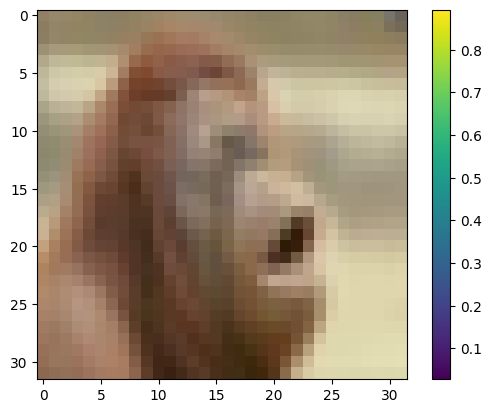

In [39]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

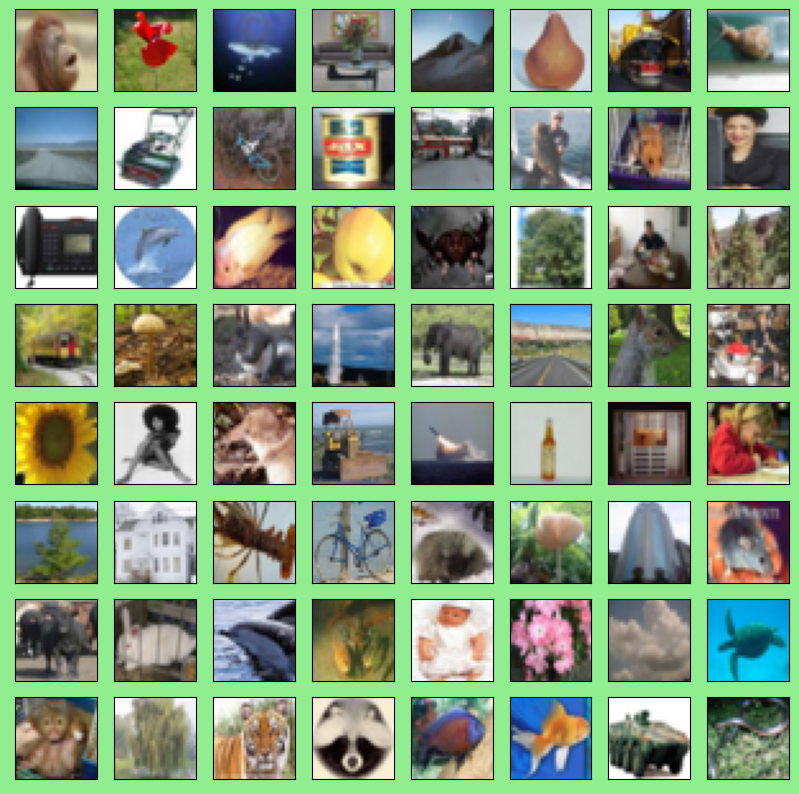

In [40]:
plt.figure(figsize=(10,10),facecolor="lightgreen")
for i in range(64): # 25 images
  plt.subplot(8,8,i+1) # matrix of 5 X 5 array
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i])
plt.show()

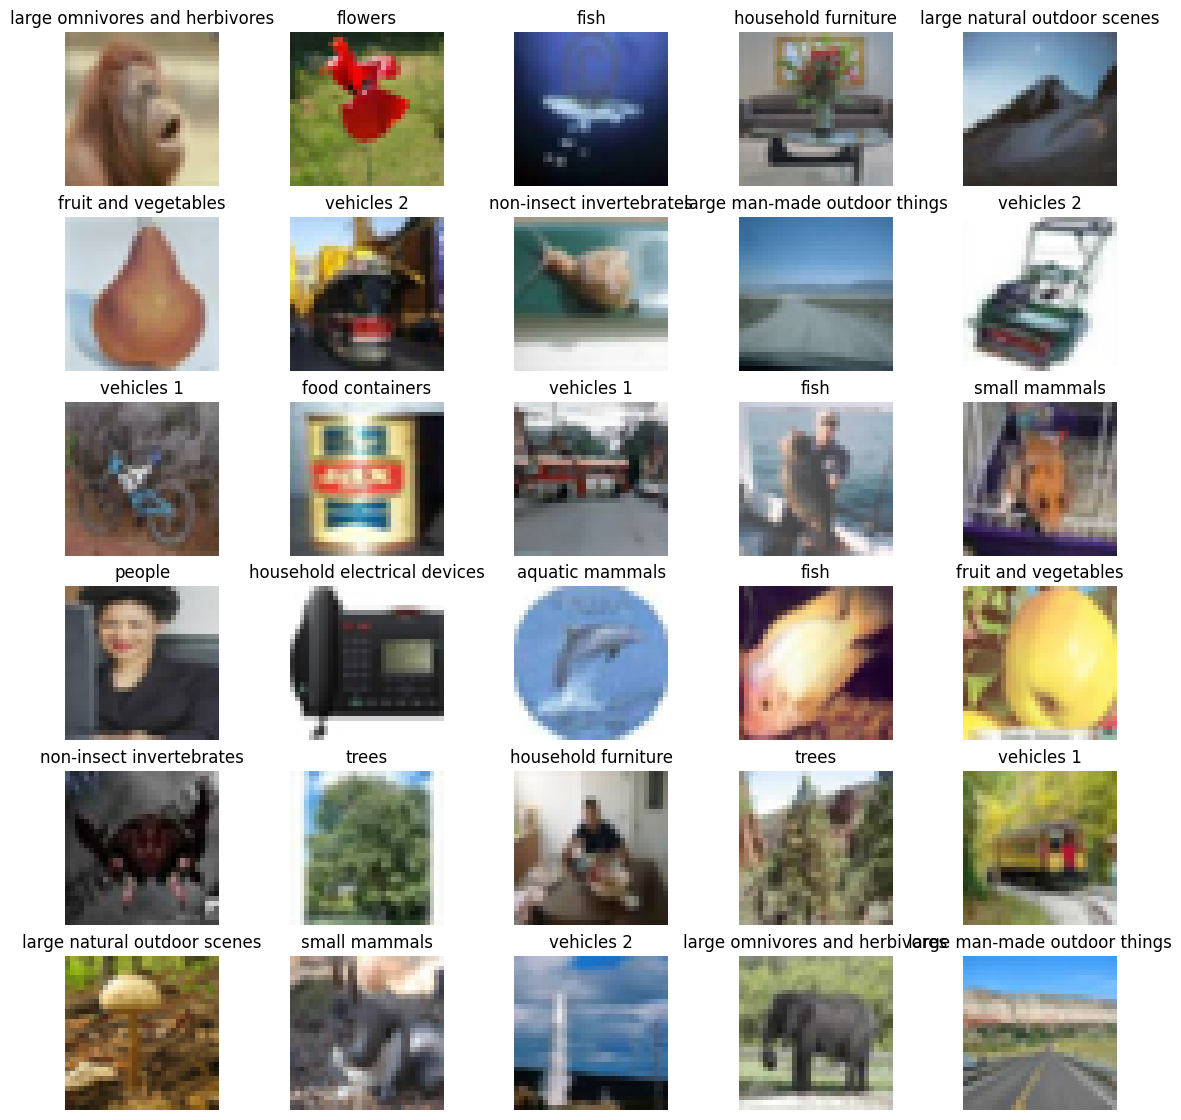

In [41]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

## Objectives/Tasks

- Be able to accurately identify the test images fed to the model
- Get highest possible accuracy and loss (>90% accuracy)
- Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [ ]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

# Using a pretrained EfficientNetB0

In [ ]:
import efficientnet.keras as efn 

efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

In [44]:
efnb0.trainable = False

sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 31, 31, 32)        416       
                                                                 
 flatten_2 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 20)                615060    
                                                                 
Total params: 615,476
Trainable params: 615,476
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1407/1407 [==============================] - 15s 10ms/step - loss: 2.3069 - accuracy: 0.3048 - val_loss: 2.1163 - val_accuracy: 0.3678
Epoch 2/10
1407/1407 [==============================] - 13s 9ms/step - loss: 1.9550 - accuracy: 0.4138 - val_loss: 2.0551 - val_accuracy: 0.3834
Epoch 3/10
1407/1407 

In [45]:
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])
hist = model.fit_generator(train_generator,validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = [es, rlrop])
model.save_weights("efficientnet_models/best_weight.h5")

313/313 [==============================] - 2s 6ms/step - loss: 2.4095 - accuracy: 0.3773
[2.4094650745391846, 0.3772999942302704]


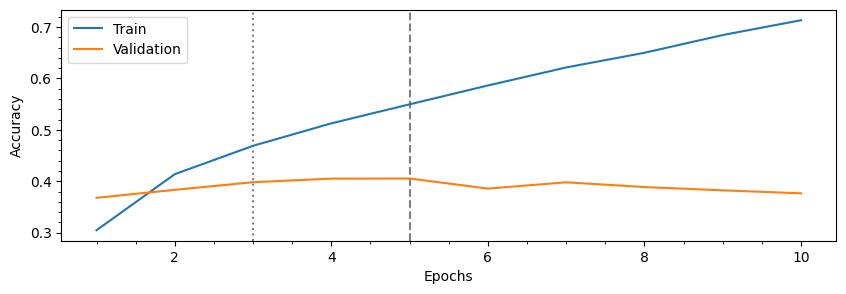

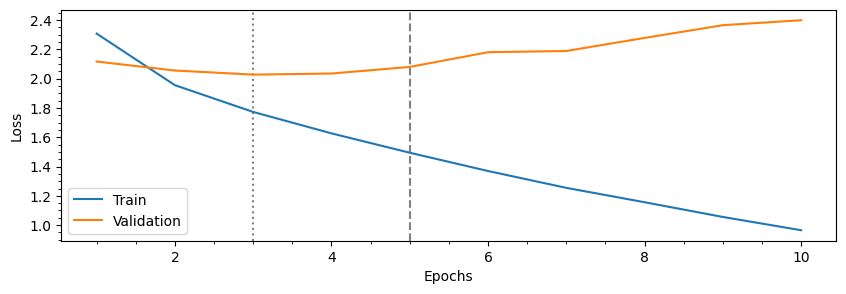

In [46]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

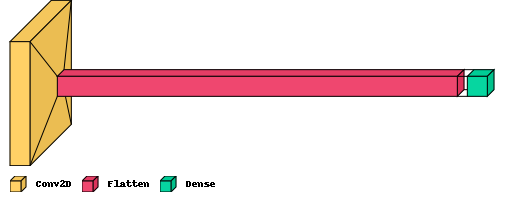

In [47]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [ ]:
# model.load_weights("../input/%s/best_weight.h5" % (os.listdir('../input')[0]))
print("The Accuracy on the validation data : {:.2f}%".format(100 * model.evaluate_generator(valid_generator, verbose = 1)[-1]))

In [48]:
# baseline_coarse_model.save_weights("models/baseline-coarse-model.h5")

### Baseline Fine Model

In [49]:
baseline_fine_model = Sequential([
    layers.Conv2D(32, (2,2), activation="relu", input_shape=(32, 32, 3)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(100)
])

#copy pasted from documentation
baseline_fine_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

baseline_fine_model.summary()

baseline_fine_model_history = baseline_fine_model.fit(x_train, y_train_fine, epochs=10, validation_data=(x_val, y_val_fine))
baseline_fine_model_history

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 31, 31, 32)        416       
                                                                 
 flatten_3 (Flatten)         (None, 30752)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               3075300   
                                                                 
Total params: 3,075,716
Trainable params: 3,075,716
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1407/1407 [==============================] - 35s 24ms/step - loss: 3.4793 - accuracy: 0.2064 - val_loss: 3.1341 - val_accuracy: 0.2712
Epoch 2/10
1407/1407 [==============================] - 20s 14ms/step - loss: 2.5267 - accuracy: 0.3876 - val_loss: 3.0747 - val_accuracy: 0.2880
Epoch 3/10
1407/

In [50]:
# evaluating baseline modes
print(baseline_fine_model.evaluate(x_test, y_test_fine))

313/313 [==============================] - 2s 8ms/step - loss: 5.4921 - accuracy: 0.2569
[5.492080211639404, 0.25690001249313354]


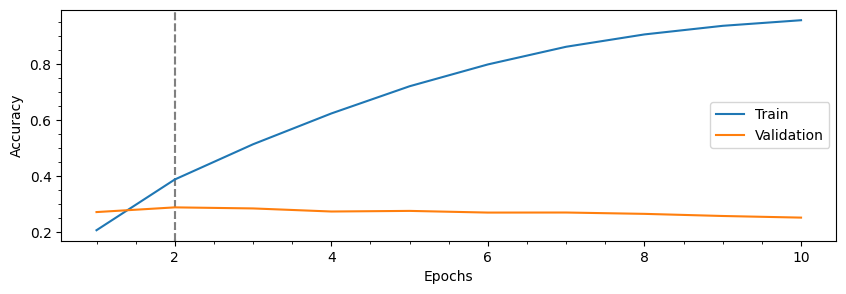

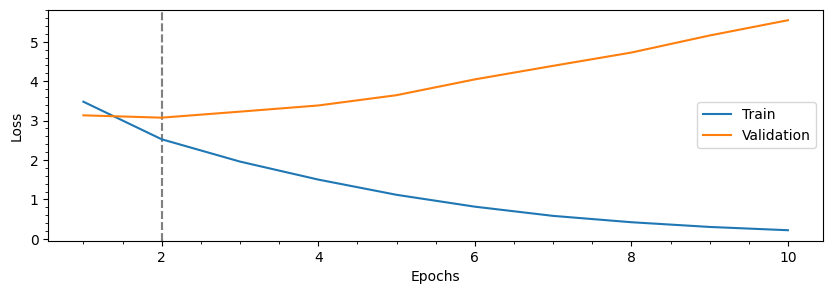

In [53]:
max_val_acc_epoch = np.argmax(list(baseline_fine_model_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_fine_model_history.history['val_loss']))+1
epochs = range(1, len(baseline_fine_model_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_fine_model_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_fine_model_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_fine_model_history.history['loss'], label='Train')
plt.plot(epochs,baseline_fine_model_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

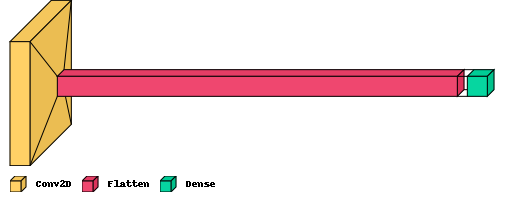

In [54]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_fine_model, legend=True)

In [55]:
baseline_fine_model.save_weights("models/baseline-fine-model.h5")

In [56]:
def progressive_with_dropout_randaug(
    model,
    checkpoint,
    getAcc,
    getLoss,
    log,
    data_name="cifar10",
    total_epochs=36,
    batch_size=64,
    target_shapes=[128],
    dropouts=[0.4],
    dropout_layer=-2,
    magnitudes=[0]):
    
    stages = min([len(target_shapes), len(dropouts), len(magnitudes)])
    for stage, target_shape, dropout, magnitude in zip(range(stages), target_shapes, dropouts, magnitudes):
        print(">>>> stage: {}/{}, target_shape: {}, dropout: {}, magnitude: {}".format(stage + 1, stages, target_shape, dropout, magnitude))
        if len(dropouts) > 1 and isinstance(model.layers[dropout_layer], keras.layers.Dropout):
            print(">>>> Changing dropout rate to:", dropout)
            model.layers[dropout_layer].rate = dropout
        target_shape = (target_shape, target_shape)
        train_dataset, test_dataset = init_dataset(data_name=data_name, target_shape=target_shape, batch_size=batch_size, magnitude=magnitude, keep_shape=True)
        opt = tf.keras.optimizers.Adam()
        top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')
        model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])
        checkpoint = checkpoint
        getAcc = getAcc
        getLoss = getLoss
        log = log
        initial_epoch = stage * total_epochs // stages
        epochs = (stage + 1) * total_epochs // stages
        history = model.fit(
            train_dataset,
            epochs=epochs,
            initial_epoch=initial_epoch,
            validation_data=test_dataset,
        callbacks=[checkpoint,getAcc,getLoss,log],
        )

In [57]:
class ProcessImage:
    def __init__(self, target_shape=(300, 300), magnitude=0, keep_shape=False):
        self.target_shape, self.magnitude, self.keep_shape = target_shape, magnitude, keep_shape
        self.target_shape = target_shape if len(target_shape) == 2 else target_shape[:2]
        if magnitude > 0:
            from keras_efficientnet_v2 import augment
            translate_const, cutout_const = 100, 40
            print(
                ">>>> RandAugment: magnitude = %d, translate_const = %d, cutout_const = %d"
                % (magnitude, translate_const, cutout_const)
            )
            aa = augment.RandAugment(magnitude=magnitude, translate_const=translate_const, cutout_const=cutout_const)
            self.process = lambda img: aa.distort(img)
        elif magnitude == 0:
            self.process = lambda img: tf.image.random_flip_left_right(img)
        else:
            self.process = lambda img: img
    def __call__(self, datapoint):
        image = datapoint["image"]
        if self.keep_shape:
            cropped_shape = tf.reduce_min(tf.keras.backend.shape(image)[:2])
            image = tf.image.random_crop(image, (cropped_shape, cropped_shape, 3))
        input_image = tf.image.resize(image, self.target_shape,method = tf.image.ResizeMethod.BICUBIC)
        label = datapoint["label"]
        input_image = self.process(input_image)
        input_image = (tf.cast(input_image, tf.float32) - 127.5) / 128
        return input_image, label


def init_dataset(data_name="test123",target_shape=(300, 300), batch_size=64, all = 10000,buffer_size=1000, info_only=False, magnitude=0, keep_shape=False):
    train,test = tfds.load(data_name,split=['train','test'])
    dataset, info = tfds.load(data_name, with_info=True)
    num_classes = info.features["label"].num_classes
    total_images = info.splits["train"].num_examples
    if info_only:
        return total_images, num_classes

    AUTOTUNE = tf.data.AUTOTUNE
    train_process = ProcessImage(target_shape, magnitude, keep_shape=keep_shape)
    train = train.map(lambda xx: train_process(xx), num_parallel_calls=AUTOTUNE)

    test_process = ProcessImage(target_shape, magnitude=-1, keep_shape=keep_shape)
    test = test.map(lambda xx: test_process(xx))

    as_one_hot = lambda x, y: (x, tf.one_hot(y, num_classes))
    train_dataset = train.shuffle(buffer_size).batch(batch_size).map(as_one_hot).prefetch(buffer_size=AUTOTUNE)
    test_dataset = test.batch(batch_size).map(as_one_hot)
    return train_dataset,test_dataset

In [58]:
input = tf.keras.Input((32,32,3))
x = Conv2D(32,(3,3),(1,1),'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)
x = Conv2D(64,(3,3),(2,2),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)
x = Conv2D(128,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(100,'softmax')(x)
opt = tf.keras.optimizers.Adam()
baseline = keras.models.Model(inputs=input,outputs = x)
top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')

baseline.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])
log_base = CSVLogger('tmp/baselineB.csv',separator = ',',append=False)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineB.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineB_Acc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineB_Loss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')

In [59]:
input_shape = ( 32, 32, 3)
batch_size = 128
train_dataset, test_dataset = init_dataset(data_name="cifar100", target_shape=input_shape, batch_size=batch_size,magnitude=-1,keep_shape=True)

In [61]:
baseline_history = baseline.fit(train_dataset,epochs=10,validation_data=test_dataset,callbacks=[checkpoint,getAcc,getLoss,log_base])

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 1.4275 - accuracy: 0.5953 - top_3_accuracy: 0.8056
Epoch 1: saving model to tmp/checkpoint\baselineB.hdf5

Epoch 1: val_accuracy improved from 0.42650 to 0.42980, saving model to tmp/checkpoint\baselineB_Acc.hdf5

Epoch 1: val_loss did not improve from 2.22218
391/391 [==============================] - 30s 77ms/step - loss: 1.4276 - accuracy: 0.5953 - top_3_accuracy: 0.8056 - val_loss: 2.3061 - val_accuracy: 0.4298 - val_top_3_accuracy: 0.6404
Epoch 2/10
390/391 [============================>.] - ETA: 0s - loss: 1.3139 - accuracy: 0.6245 - top_3_accuracy: 0.8265
Epoch 2: saving model to tmp/checkpoint\baselineB.hdf5

Epoch 2: val_accuracy improved from 0.42980 to 0.44430, saving model to tmp/checkpoint\baselineB_Acc.hdf5

Epoch 2: val_loss improved from 2.22218 to 2.21266, saving model to tmp/checkpoint\baselineB_Loss.hdf5
391/391 [==============================] - 28s 70ms/step - loss: 1.3140 - accuracy: 0.6245 - to

In [62]:
baseline.load_weights('tmp/checkpoint/baselineB_Acc.hdf5')
scoreAcc = baseline.evaluate(test_dataset)
baseline.load_weights('tmp/checkpoint/baselineB_Loss.hdf5')
scoreLoss = baseline.evaluate(test_dataset)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

79/79 [==============================] - 3s 32ms/step - loss: 2.2127 - accuracy: 0.4443 - top_3_accuracy: 0.6656
Best Acc Test Loss: 2.2796640396118164
Best Acc Test Accuracy: 45.129999999999995 %
Best Loss Test Loss: 2.212655782699585
Best Loss Test Accuracy: 44.43 %


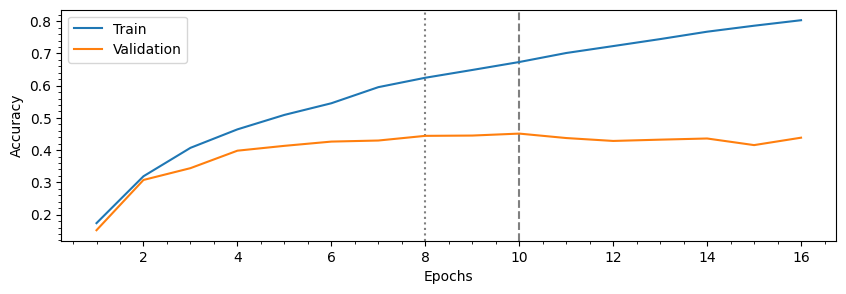

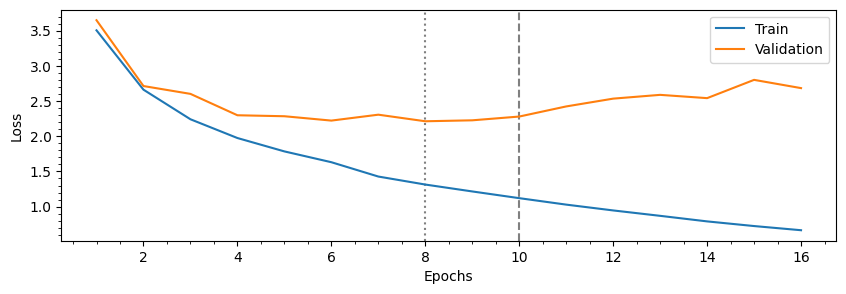

In [63]:
data = pd.read_csv('tmp/baselineB.csv')
max_val_acc_epoch = np.argmax(data['val_accuracy'])+1
max_val_loss_epoch = np.argmin(data['val_loss'])+1
epochs = range(1, len(data['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['accuracy'], label='Train')
plt.plot(epochs,data['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['loss'], label='Train')
plt.plot(epochs,data['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

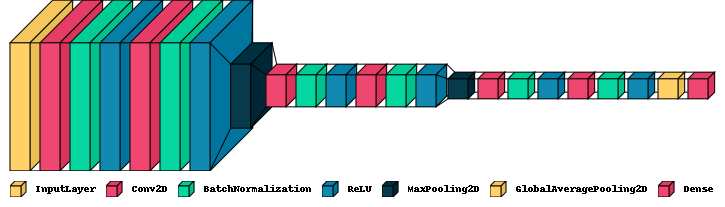

In [64]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline, legend=True)

In [65]:
baseline.save_weights("models/general-baseline-model.h5")

## Resnet50 architecture

In [35]:
# ATTENTION. train using school lab computer with GPU

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

def res_identity(x, filters): 
    #renet block where dimension doesnot change.
    #The skip connection is just simple identity conncection
    #we will have 3 blocks and then input will be added

    x_skip = x # this will be used for addition with the residual block 
    f1, f2 = filters

    #first block 
    x = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #second block # bottleneck (but size kept same with padding)
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # third block activation used after adding the input
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    # x = Activation(activations.relu)(x)

    # add the input 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def res_conv(x, s, filters):
    '''
    here the input size changes''' 
    x_skip = x
    f1, f2 = filters

    # first block
    x = Conv2D(f1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x)
    # when s = 2 then it is like downsizing the feature map
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    # second block
    x = Conv2D(f1, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)

    #third block
    x = Conv2D(f2, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    # shortcut 
    x_skip = Conv2D(f2, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_regularizer=l2(0.001))(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # add 
    x = Add()([x, x_skip])
    x = Activation(activations.relu)(x)

    return x

def resnet50(num_class):
    input_im = Input(shape=(32,32,3))
    x = ZeroPadding2D(padding=(3, 3))(input_im)

    # 1st stage
    # here we perform maxpooling, see the figure above
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation(activations.relu)(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #2nd stage 
    # frm here on only conv block and identity block, no pooling

    x = res_conv(x, s=1, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))
    x = res_identity(x, filters=(64, 256))

    # 3rd stage

    x = res_conv(x, s=2, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))
    x = res_identity(x, filters=(128, 512))

    # 4th stage

    # x = res_conv(x, s=2, filters=(256, 1024))
    # x = res_identity(x, filters=(256, 1024))
    # x = res_identity(x, filters=(256, 1024))
    # x = res_identity(x, filters=(256, 1024))
    # x = res_identity(x, filters=(256, 1024))
    # x = res_identity(x, filters=(256, 1024))

    # 5th stage

    # x = res_conv(x, s=2, filters=(512, 2048))
    # x = res_identity(x, filters=(512, 2048))
    # x = res_identity(x, filters=(512, 2048))

    # ends with average pooling and dense connection

    # x = AveragePooling2D((2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(num_class, activation='softmax', kernel_initializer='he_normal')(x) #multi-class

    # define the model 

    model = Model(inputs=input_im, outputs=x, name='Resnet50')

    return model

resnet50_model = resnet50(20)
resnet50_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [36]:
import scipy
train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
batch_size=64

train_lab_categorical_coarse = tf.keras.utils.to_categorical(
    y_train_coarse, num_classes=20, dtype='uint8')

train_set_conv = train_DataGen.flow(x_train, train_lab_categorical_coarse, batch_size=batch_size)

resnet_history = resnet50_model.fit(train_set_conv, epochs=30)

Epoch 1/30
704/704 [==============================] - 34s 41ms/step - loss: 6.1111 - acc: 0.2310
Epoch 2/30
704/704 [==============================] - 31s 43ms/step - loss: 4.2906 - acc: 0.3194
Epoch 3/30
704/704 [==============================] - 30s 43ms/step - loss: 3.2888 - acc: 0.3608
Epoch 4/30
704/704 [==============================] - 31s 45ms/step - loss: 2.8073 - acc: 0.3865
Epoch 5/30
704/704 [==============================] - 34s 49ms/step - loss: 2.4266 - acc: 0.4241
Epoch 6/30
704/704 [==============================] - 36s 51ms/step - loss: 2.3333 - acc: 0.4302
Epoch 7/30
704/704 [==============================] - 38s 53ms/step - loss: 2.2320 - acc: 0.4520
Epoch 8/30
704/704 [==============================] - 42s 60ms/step - loss: 2.1486 - acc: 0.4678
Epoch 9/30
704/704 [==============================] - 36s 51ms/step - loss: 2.1592 - acc: 0.4746
Epoch 10/30
704/704 [==============================] - 33s 48ms/step - loss: 2.1241 - acc: 0.4720
Epoch 11/30
704/704 [========

In [37]:
resnet50_model.evaluate(x=x_test, y=tf.keras.utils.to_categorical(
    y_test_coarse, num_classes=20, dtype='uint8'))

313/313 [==============================] - 5s 13ms/step - loss: 2.0035 - acc: 0.4681


[2.00347900390625, 0.46810001134872437]

In [38]:
# fine model
resnet50_model_fine = resnet50(100)
resnet50_model_fine.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

import scipy
train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
batch_size=64

train_lab_categorical_fine = tf.keras.utils.to_categorical(
    y_train_fine, num_classes=100, dtype='uint8')

train_set_conv = train_DataGen.flow(x_train, train_lab_categorical_fine, batch_size=batch_size)

resnet_history = resnet50_model_fine.fit(train_set_conv, epochs=30)


Epoch 1/30
704/704 [==============================] - 39s 50ms/step - loss: 7.7149 - acc: 0.1293
Epoch 2/30
704/704 [==============================] - 29s 42ms/step - loss: 5.1986 - acc: 0.2148
Epoch 3/30
704/704 [==============================] - 28s 40ms/step - loss: 4.1163 - acc: 0.2662
Epoch 4/30
704/704 [==============================] - 28s 40ms/step - loss: 3.4343 - acc: 0.3211
Epoch 5/30
704/704 [==============================] - 33s 47ms/step - loss: 3.1058 - acc: 0.3518
Epoch 6/30
704/704 [==============================] - 34s 48ms/step - loss: 2.9130 - acc: 0.3765
Epoch 7/30
704/704 [==============================] - 31s 44ms/step - loss: 2.7970 - acc: 0.3917
Epoch 8/30
704/704 [==============================] - 31s 44ms/step - loss: 2.6804 - acc: 0.4108
Epoch 9/30
704/704 [==============================] - 29s 41ms/step - loss: 2.5983 - acc: 0.4226
Epoch 10/30
704/704 [==============================] - 28s 40ms/step - loss: 2.5347 - acc: 0.4345
Epoch 11/30
704/704 [========

In [39]:
resnet50_model_fine.evaluate(x=x_test, y=tf.keras.utils.to_categorical(
    y_test_fine, num_classes=100, dtype='uint8'))

313/313 [==============================] - 5s 15ms/step - loss: 2.9155 - acc: 0.4064


[2.9154891967773438, 0.40639999508857727]

In [40]:
# # accuracy_val = resnet_history.history['val_accuracy']
# accuracy = resnet_history.history['accuracy']
# epoch = range(0,10)
# plt.plot(epoch, accuracy, 'g', label='accuracy')
# plt.plot(epoch, accuracy_val, 'b', label='validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

In [41]:
# plt.plot(resnet_history.history['accuracy'], label='training accuracy')
# plt.plot(resnet_history.history['val_accuracy'], label='validation accuracy')
# plt.legend()

# plt.show()

In [42]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(resnet50_model, legend=True)

In [43]:
# tuner.search(x_train, train_lab_categorical_coarse, epochs=50, validation_split=0.2, callbacks=[stop_early])

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

In [44]:
# # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(x_train, train_lab_categorical_coarse, epochs=50, validation_split=0.2)

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

In [45]:
# hypermodel = tuner.hypermodel.build(best_hps)

# # Retrain the model
# hypermodel.fit(x_train, train_lab_categorical_coarse, epochs=best_epoch, validation_split=0.2)

In [46]:
# eval_result = hypermodel.evaluate(x_test, y_test_coarse)
# print("[test loss, test accuracy]:", eval_result)

In [47]:
# tf.keras.utils.plot_model(
# resnet50_model,
# to_file="model.png",
# show_shapes=True,
# show_dtype=False,
# show_layer_names=True,
# rankdir="TB",
# expand_nested=True,
# dpi=96,
# layer_range=None,
# show_layer_activations=True,
# )

## EfficientNetV2 Architecture

In [48]:
# # efficient net 2
# from tensorflow.keras.applications.efficientnet import *

# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers

# import warnings
# warnings.filterwarnings('ignore')

# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_coarse))
# train_dataset = train_dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
# train_dataset = train_dataset.batch(64).prefetch(AUTOTUNE)

# img_augmentation = Sequential(
#     [
#         layers.RandomRotation(factor=0.15),
#         layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
#         layers.RandomFlip(),
#         layers.RandomContrast(factor=0.1),
#     ],
#     name="img_augmentation",
# )

# def build_model(num_classes):
#     inputs = layers.Input(shape=(32, 32, 3))
#     x = img_augmentation(inputs)
#     model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

#     # Freeze the pretrained weights
#     model.trainable = False

#     # Rebuild top
#     x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
#     x = layers.BatchNormalization()(x)

#     top_dropout_rate = 0.2
#     x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#     outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

#     # Compile
#     model = tf.keras.Model(inputs, outputs, name="EfficientNet")
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
#     model.compile(
#         optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
#     )
#     return model

# ef_model = build_model(20)
# ef_model.fit(train_dataset, epochs=5)